# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [1]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

corpus_visualizacion = newsgroupsdocs[:7] # solo los primeros 7
doc_names = [f"Doc {i}" for i in range(len(corpus_visualizacion))]


### Matriz de Frecuencia de Términos (TF)

In [3]:
# Usamos stop_words='english' para filtrar palabras comunes
count_vec = CountVectorizer(stop_words='english')
tf_matrix = count_vec.fit_transform(corpus_visualizacion)
feature_names_tf = count_vec.get_feature_names_out()

tf_df = pd.DataFrame(
    tf_matrix.toarray(),
    columns=feature_names_tf,
    index=doc_names
)
print(tf_df)

       0055  10  1280  150  20  200th  20ms  214  241  2mb  ...  wanting  \
Doc 0     0   0     0    0   0      0     0    0    0    0  ...        0   
Doc 1     0   0     1    0   0      0     0    0    0    1  ...        0   
Doc 2     0   0     0    0   0      0     0    0    0    0  ...        0   
Doc 3     0   1     0    0   0      0     1    0    0    0  ...        1   
Doc 4     0   0     0    1   1      0     0    0    0    0  ...        0   
Doc 5     0   0     0    0   0      1     0    0    0    0  ...        0   
Doc 6     1   0     0    0   0      0     0    2    2    0  ...        0   

       wants  watch  weapons  women  work  worked  workers  worse  years  
Doc 0      0      1        0      0     0       0        0      1      0  
Doc 1      0      0        0      0     0       0        0      0      0  
Doc 2      0      0        4      1     0       0        1      0      1  
Doc 3      1      0        0      0     0       0        0      0      0  
Doc 4      0    

### Frecuencia de Documentos (DF)

In [4]:
df_counts = np.sum(tf_matrix.toarray() > 0, axis=0)

# Visualizar DF en un DataFrame (requiere pandas)
df_df = pd.DataFrame({
    'Término': feature_names_tf,
    'DF': df_counts
})

print (df_df)

     Término  DF
0       0055   1
1         10   1
2       1280   1
3        150   1
4         20   1
..       ...  ..
272     work   1
273   worked   1
274  workers   1
275    worse   1
276    years   1

[277 rows x 2 columns]


### TF-IDF

In [5]:
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(corpus_visualizacion)
feature_names_tfidf = tfidf_vec.get_feature_names_out()

idf_df = pd.DataFrame({
    'Término': feature_names_tfidf,
    'IDF_Score': tfidf_vec.idf_
})

# Términos menos importantes 
print("\n   Términos con Menor IDF (más comunes):")
print(idf_df.sort_values(by='IDF_Score').head(5))


# Términos más importantes 
print("\n   Términos con Mayor IDF (más raros/importantes):")
print(idf_df.sort_values(by='IDF_Score', ascending=False).head(5))

print("4. Matriz Final TF-IDF (Normalizada)")
tfidf_df_final = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names_tfidf,
    index=doc_names
)
print(tfidf_df_final.round(3))


   Términos con Menor IDF (más comunes):
    Término  IDF_Score
260    used   1.693147
75    doing   1.980829
43      bus   1.980829
249     try   1.980829
155     new   1.980829

   Términos con Mayor IDF (más raros/importantes):
      Término  IDF_Score
0        0055   2.386294
187      pulp   2.386294
173  playoffs   2.386294
174    policy   2.386294
175      post   2.386294
4. Matriz Final TF-IDF (Normalizada)
        0055     10   1280    150     20  200th   20ms    214    241    2mb  \
Doc 0  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
Doc 1  0.000  0.000  0.153  0.000  0.000  0.000  0.000  0.000  0.000  0.153   
Doc 2  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
Doc 3  0.000  0.075  0.000  0.000  0.000  0.000  0.075  0.000  0.000  0.000   
Doc 4  0.000  0.000  0.000  0.123  0.123  0.000  0.000  0.000  0.000  0.000   
Doc 5  0.000  0.000  0.000  0.000  0.000  0.178  0.000  0.000  0.000  0.000   
Doc 6  0.247  0.000  0.000  

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

print("Entrenando el TfidfVectorizer en todo el corpus (18,846 documentos)...")

# Asumimos que 'newsgroupsdocs' ya existe por la Parte 0
# Creamos un NUEVO vectorizador para el corpus completo
tfidf_vec_full = TfidfVectorizer(stop_words='english')

# Ajustamos y transformamos el corpus COMPLETO
# Esto crea una "sparse matrix" (matriz dispersa) que sí cabe en memoria
tfidf_matrix_full = tfidf_vec_full.fit_transform(newsgroupsdocs)

print(f"Matriz TF-IDF (sparse) creada. Dimensiones: {tfidf_matrix_full.shape}")
print("¡Vectorizador listo para buscar!")

Entrenando el TfidfVectorizer en todo el corpus (18,846 documentos)...
Matriz TF-IDF (sparse) creada. Dimensiones: (18846, 134101)
¡Vectorizador listo para buscar!


In [7]:
# 1. Dada una consulta, construye el vector de consulta
#    (Puedes cambiar este texto por el que quieras buscar)
query = "computer graphics algorithms"

print(f"Consulta (Query): '{query}'")

# Usamos .transform() en el vectorizador YA ENTRENADO (tfidf_vec_full)
query_vector = tfidf_vec_full.transform([query])

print(f"Vector de consulta (sparse) creado. Dimensiones: {query_vector.shape}")

Consulta (Query): 'computer graphics algorithms'
Vector de consulta (sparse) creado. Dimensiones: (1, 134101)


In [8]:
# 2. Calcula la similitud coseno
print("Calculando similitud coseno contra 18,846 documentos...")

# Compara el vector 1xN de la consulta contra la matriz 18846xN
cosine_similarities = cosine_similarity(query_vector, tfidf_matrix_full).flatten()

print("Cálculo finalizado.")

# 3. Genera un ranking de los documentos
#    np.argsort() nos da los *índices* de los documentos, de menor a mayor score
#    Usamos [::-1] para invertirlos (de mayor a menor score)
ranking_indices = np.argsort(cosine_similarities)[::-1]

print("Ranking de índices de documentos generado.")

Calculando similitud coseno contra 18,846 documentos...
Cálculo finalizado.
Ranking de índices de documentos generado.


In [9]:
print("Parte 2: Top 10 Documentos Relevantes (TF-IDF)")

top_n = 10
top_n_indices = ranking_indices[:top_n] # Tomamos los 10 primeros índices

# Preparamos los datos para el DataFrame
top_docs_data = []
for i in top_n_indices:
    # i es el índice (ID) del documento
    top_docs_data.append({
        'Documento_ID': i,
        'Score_TF-IDF': cosine_similarities[i],
        'Texto_Documento': newsgroupsdocs[i][:250] + "..." # Mostramos los primeros 250 caracteres
    })

# Creamos y mostramos el DataFrame (requiere pandas)
ranking_df_tfidf = pd.DataFrame(top_docs_data)
print(ranking_df_tfidf)

Parte 2: Top 10 Documentos Relevantes (TF-IDF)
   Documento_ID  Score_TF-IDF  \
0          8574      0.368576   
1         12488      0.364363   
2         15330      0.357751   
3          8050      0.344685   
4         14852      0.310982   
5          7566      0.290916   
6         16571      0.280669   
7         13216      0.278546   
8           951      0.271914   
9         10141      0.266156   

                                     Texto_Documento  
0  \nThere's an out for him.  The announcement ta...  
1  EUROPEAN COMPUTER RESEARCH CENTRE\n\nResearch ...  
2  \nThis sounds wonderful, but it seems no one e...  
3  Technion - Israel Institute of Technology\n   ...  
4  \n\tYes, that's known as "Bresenhams Run Lengt...  
5  Within the next several months I'll be looking...  
6  \nI'm also interested in info both public doma...  
7  Is there a comp.graphics FAQ and if so, where?...  
8  Concerning the proposed newsgroup split, I per...  
9  Hello netters\n\nSorry, I don't know

## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [10]:
# 1. Instalar la librería para BM25
!pip install rank_bm25

# 2. Importar nltk y descargar paquetes necesarios (stopwords y tokenizador)
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from rank_bm25 import BM25Okapi
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Cargamos las stopwords en inglés
stop_words_en = set(stopwords.words('english'))

def preprocess(text):

    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word not in stop_words_en]
    return cleaned_tokens

print("Función 'preprocess' definida.")

Función 'preprocess' definida.


In [12]:
print(f"Tokenizando los {len(newsgroupsdocs)} documentos para BM25...")
tokenized_corpus = [preprocess(doc) for doc in newsgroupsdocs]

print("Corpus tokenizado exitosamente.")
print(f"Ejemplo del primer documento tokenizado: {tokenized_corpus[0][:15]}...") # Muestra los primeros 15 tokens

Tokenizando los 18846 documentos para BM25...
Corpus tokenizado exitosamente.
Ejemplo del primer documento tokenizado: ['sure', 'bashers', 'pens', 'fans', 'pretty', 'confused', 'lack', 'kind', 'posts', 'recent', 'pens', 'massacre', 'devils', 'actually', 'bit']...


In [13]:
print("Indexando el corpus con BM25...")
# 1. Inicializar y "entrenar" el modelo BM25

bm25 = BM25Okapi(tokenized_corpus, k1=1.5, b=0.75)
print(f"Usando la misma consulta: '{query}'")

tokenized_query = preprocess(query)
print(f"Consulta tokenizada: {tokenized_query}")

print("Calculando scores BM25...")
bm25_scores = bm25.get_scores(tokenized_query)

print("Scores calculados.")

Indexando el corpus con BM25...
Usando la misma consulta: 'computer graphics algorithms'
Consulta tokenizada: ['computer', 'graphics', 'algorithms']
Calculando scores BM25...
Scores calculados.


In [14]:

print("Parte 3: Top 10 Documentos Relevantes (BM25)")
print(f"Resultados para la consulta: '{query}'")

ranking_indices_bm25 = np.argsort(bm25_scores)[::-1]

top_n = 10
top_n_indices_bm25 = ranking_indices_bm25[:top_n]

top_docs_data_bm25 = []
for i in top_n_indices_bm25:
    top_docs_data_bm25.append({
        'Documento_ID': i,
        'Score_BM25': bm25_scores[i],
        'Texto_Documento': newsgroupsdocs[i][:250] + "..."
    })


ranking_df_bm25 = pd.DataFrame(top_docs_data_bm25)
print(ranking_df_bm25)

print("\n--- Ranking TF-IDF ---")
print(ranking_df_tfidf[['Documento_ID', 'Score_TF-IDF']].head())

print("\n--- Ranking BM25 ---")
print(ranking_df_bm25[['Documento_ID', 'Score_BM25']].head())



Parte 3: Top 10 Documentos Relevantes (BM25)
Resultados para la consulta: 'computer graphics algorithms'
   Documento_ID  Score_BM25                                    Texto_Documento
0         14852   19.267551  \n\tYes, that's known as "Bresenhams Run Lengt...
1         12488   17.849377  EUROPEAN COMPUTER RESEARCH CENTRE\n\nResearch ...
2          3752   17.412315  \nGraeme> \tYes, that's known as "Bresenhams R...
3          8050   14.150429  Technion - Israel Institute of Technology\n   ...
4           951   14.032043  Concerning the proposed newsgroup split, I per...
5         10921   13.891983  : Concerning the proposed newsgroup split, I p...
6          5776   13.399302  \nI usually use "Algorithms for graphics and i...
7          2562   13.372696  \n+In article <1993May7.211312.10403@bert.eecs...
8         13298   13.119702  \nMy package is based on several articles abou...
9         11545   13.109209  : Concerning the proposed newsgroup split, I p...

--- Ranking TF-IDF ---
  

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#    Elegimos los 15 mejores de CADA modelo y los unimos.
top_n_vis = 15
top_indices_tfidf = ranking_indices[:top_n_vis]
top_indices_bm25 = ranking_indices_bm25[:top_n_vis]

combined_top_indices = np.union1d(top_indices_tfidf, top_indices_bm25)

print(f"Se compararán {len(combined_top_indices)} documentos (el Top {top_n_vis} de ambos modelos).")
comparison_df = pd.DataFrame({
    'Doc_ID_Str': [f"Doc {i}" for i in combined_top_indices],
    'Score_TFIDF': cosine_similarities[combined_top_indices],
    'Score_BM25': bm25_scores[combined_top_indices]
}, index=combined_top_indices) # Usamos los índices numéricos reales

scaler = MinMaxScaler()
comparison_df[['Score_TFIDF_Norm', 'Score_BM25_Norm']] = scaler.fit_transform(
    comparison_df[['Score_TFIDF', 'Score_BM25']]
)

print("\nDataFrame de scores normalizados (primeros 5):")
print(comparison_df.head())

Se compararán 24 documentos (el Top 15 de ambos modelos).

DataFrame de scores normalizados (primeros 5):
     Doc_ID_Str  Score_TFIDF  Score_BM25  Score_TFIDF_Norm  Score_BM25_Norm
951     Doc 951     0.271914   14.032043          0.595641         0.728273
1590   Doc 1590     0.190171   11.789155          0.253687         0.611866
2562   Doc 2562     0.231231   13.372696          0.425451         0.694053
3752   Doc 3752     0.190807   17.412315          0.256347         0.903712
4574   Doc 4574     0.193776   12.250658          0.268767         0.635818



Generando gráfico de comparación...
Gráfico de comparación guardado como 'tfidf_vs_bm25_comparison.png'


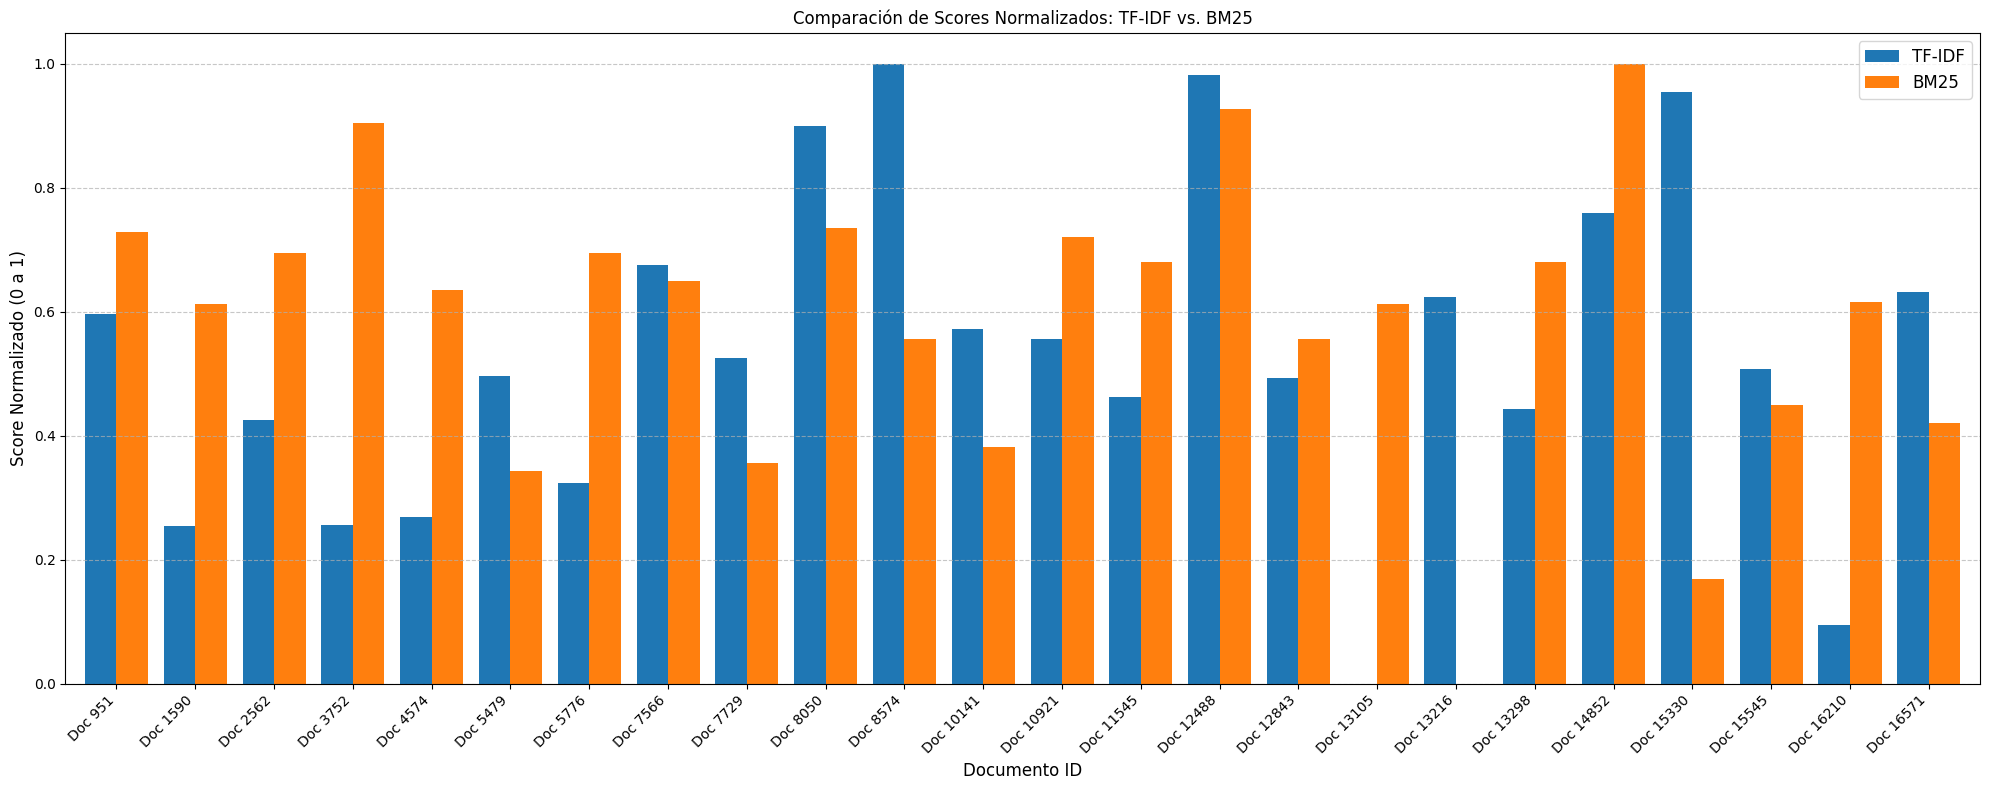

In [16]:
print("\nGenerando gráfico de comparación...")

ax = comparison_df[['Score_TFIDF_Norm', 'Score_BM25_Norm']].plot(
    kind='bar',
    figsize=(20, 8),
    width=0.8,
    title='Comparación de Scores Normalizados: TF-IDF vs. BM25'
)

ax.set_xlabel('Documento ID', fontsize=12)
ax.set_ylabel('Score Normalizado (0 a 1)', fontsize=12)
ax.set_xticklabels(comparison_df['Doc_ID_Str'], rotation=45, ha='right')
ax.legend(["TF-IDF", "BM25"], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.savefig("tfidf_vs_bm25_comparison.png")

print("Gráfico de comparación guardado como 'tfidf_vs_bm25_comparison.png'")

### Parte 4: Análisis de la Comparación Visual

El gráfico muestra qué modelo prefirió cada documento. Si la barra azul TF-IDF es más alta, ese modelo se le da más importancia, si la naranja BM25 es más alta, significa que BM25 lo priorizó. Aunque ambos modelos encuentran documentos sobre "computer graphics", se vera que a menudo no están de acuerdo en el orden de cuál es el más relevante.

Esto pasa por dos razones principales. Primero BM25 es más inteligente con la repetición de palabras: mientras TF-IDF le da un superpuntaje a un documento que repite computer 50 veces, BM25 dice "ya entendí" después de las primeras 5 y no le da mucho más crédito por las otras 45. Segundo, BM25 castiga a los documentos que son muy largos. Prefiere un documento corto y enfocado que mencione la palabra clave, en lugar de un documento enorme donde la palabra aparece por casualidad. Por eso BM25 a veces prefiere documentos que TF-IDF azul ignor y viceversa.

## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [17]:
query_eval = "discussions about God and atheism"
print(f"Consulta de Evaluación: '{query_eval}'")

relevant_docs_indices = set() 

# Iteramos por TODOS los 18,846 documentos
for i, doc in enumerate(newsgroupsdocs):
    doc_lower = doc.lower()
    if 'god' in doc_lower and 'atheism' in doc_lower:
        relevant_docs_indices.add(i) # 'i' es el Documento_ID

print(f"Se encontraron {len(relevant_docs_indices)} documentos que contienen 'god' y 'atheism'.")
print(f"IDs de documentos relevantes: {relevant_docs_indices}")

Consulta de Evaluación: 'discussions about God and atheism'
Se encontraron 73 documentos que contienen 'god' y 'atheism'.
IDs de documentos relevantes: {5504, 14213, 18437, 16519, 18056, 2575, 16272, 7954, 403, 2835, 5011, 5652, 1943, 4888, 7065, 14994, 16918, 10653, 11166, 12190, 17950, 18467, 14245, 15142, 5927, 9640, 17701, 5293, 2606, 12210, 821, 7989, 16567, 1341, 6465, 3394, 11073, 16065, 16452, 4038, 4040, 15050, 10059, 16202, 12109, 4302, 7505, 10705, 15699, 12373, 13782, 17365, 1624, 8792, 987, 17245, 5473, 15715, 18535, 8940, 3181, 10733, 13806, 18158, 1010, 6386, 18420, 4855, 12664, 11258, 18812, 4477, 9214}


In [18]:

print("Calculando ranking TF-IDF para la consulta de evaluación...")
query_vec_eval_tfidf = tfidf_vec_full.transform([query_eval])

cosine_sim_eval = cosine_similarity(query_vec_eval_tfidf, tfidf_matrix_full).flatten()

top_3_tfidf_indices = set(np.argsort(cosine_sim_eval)[-3:])
print("Calculando ranking BM25 para la consulta de evaluación...")
# 3d. Preprocesa la consulta para BM25
tokenized_query_eval = preprocess(query_eval)

bm25_scores_eval = bm25.get_scores(tokenized_query_eval)
top_3_bm25_indices = set(np.argsort(bm25_scores_eval)[-3:])


print("\n--- Rankings Top 3 Obtenidos ---")
print(f"Top 3 (TF-IDF): {top_3_tfidf_indices}")
print(f"Top 3 (BM25):   {top_3_bm25_indices}")

Calculando ranking TF-IDF para la consulta de evaluación...
Calculando ranking BM25 para la consulta de evaluación...

--- Rankings Top 3 Obtenidos ---
Top 3 (TF-IDF): {7505, 5652, 15142}
Top 3 (BM25):   {7505, 11073, 15142}


In [19]:

# Comparamos los 3 docs que encontró TF-IDF con nuestros docs relevantes
found_tfidf = top_3_tfidf_indices.intersection(relevant_docs_indices)
print(f"Documentos relevantes encontrados por TF-IDF: {found_tfidf}")

precision_tfidf = len(found_tfidf) / 3
print(f"Precision@3 (TF-IDF): {len(found_tfidf)} / 3 = {precision_tfidf:.2f}")



found_bm25 = top_3_bm25_indices.intersection(relevant_docs_indices)
print(f"\nDocumentos relevantes encontrados por BM25: {found_bm25}")

precision_bm25 = len(found_bm25) / 3
print(f"Precision@3 (BM25):   {len(found_bm25)} / 3 = {precision_bm25:.2f}")



if precision_bm25 > precision_tfidf:
    print("El modelo BM25 da mejores resultados para esta consulta.")
elif precision_tfidf > precision_bm25:
    print("El modelo TF-IDF da mejores resultados para esta consulta.")
else:
    print("Ambos modelos dieron el mismo resultado (empate) para esta consulta.")

Documentos relevantes encontrados por TF-IDF: {7505, 5652, 15142}
Precision@3 (TF-IDF): 3 / 3 = 1.00

Documentos relevantes encontrados por BM25: {11073, 7505, 15142}
Precision@3 (BM25):   3 / 3 = 1.00
Ambos modelos dieron el mismo resultado (empate) para esta consulta.
